# Loss Given Default and Exposure at Default Model

## Import Libraries and Load Loan Data

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the Preprocessed Loan Data

Load the dataset **loan_data_preprocessed.csv** from Preparation notebook.

In [2]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_preprocessed.csv')
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

/var/folders/hn/11hmxl5x72jg2t7k7m1krds80000gn/T/ipykernel_73873/3265462501.py:1: DtypeWarning: Columns (20,48,56,113,124,125,126,129,130,131,134,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('loan_data_preprocessed.csv')


### Explore and Prepare the Data

In [3]:
loan_data_preprocessed.shape

(2260668, 279)

Select the data from borrowers that have enough time to repay part of the remaining debt. In case of this Lending Club loan data, the accounts that were written-off (**loan_status** is either **Charged Off** or **Does not meet the credit policy. Status:Charged Off**) are selected.

In [4]:
loan_data_preprocessed['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [5]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off', 
                                                                                       'Does not meet the credit policy. Status:Charged Off'])].copy()
loan_data_defaults.head(10)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
5040,5040,NaN,NaN,8000,8000,8000.0,36 months,6.46,245.05,A,...,False,False,False,False,True,False,False,False,False,True
25963,25963,NaN,NaN,6000,6000,6000.0,36 months,14.47,206.44,C,...,False,False,False,False,False,False,False,False,True,False
41393,41393,NaN,NaN,10000,10000,10000.0,36 months,8.81,317.12,A,...,False,False,False,False,False,False,False,False,False,True
55148,55148,NaN,NaN,10000,10000,10000.0,60 months,27.27,306.97,E,...,False,False,False,False,False,False,False,False,False,True
58105,58105,NaN,NaN,35000,35000,35000.0,36 months,16.14,1232.92,C,...,False,False,False,False,True,False,False,False,False,True
60604,60604,NaN,NaN,4800,4800,4800.0,36 months,16.91,170.92,C,...,False,False,True,False,False,False,False,False,False,True
62536,62536,NaN,NaN,35000,35000,35000.0,36 months,14.47,1204.23,C,...,True,False,False,False,False,False,False,False,False,True
64081,64081,NaN,NaN,15000,15000,15000.0,36 months,11.31,493.29,B,...,False,False,False,False,True,False,False,False,False,True
67928,67928,NaN,NaN,16000,16000,15975.0,60 months,10.08,340.59,B,...,False,False,False,False,False,False,False,False,True,False
68761,68761,NaN,NaN,25000,25000,25000.0,36 months,6.46,765.77,A,...,False,False,False,False,False,False,False,False,False,True


In [6]:
loan_data_defaults['loan_status'].unique()

array(['Charged Off',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [7]:
loan_data_defaults.shape

(262416, 279)

In [8]:
pd.options.display.max_rows = None
loan_data_defaults.isnull().sum()

Unnamed: 0                                                              0
id                                                                 262416
member_id                                                          262416
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           21743
emp_length                                                          20409
home_ownership                        

## Independent Variables

Preprocess independent variables **mths_since_last_delinq**, **mths_since_last_record**, and **dti**.

In [9]:
loan_data_defaults.fillna({'mths_since_last_delinq': 0}, inplace = True)
loan_data_defaults.fillna({'mths_since_last_record': 0}, inplace = True)
loan_data_defaults.fillna({'dti': 0}, inplace = True)

## Dependent Variable

### Prepare Dependent Variable

For defaulted borrowers, **funded_amnt** reflects the total amound that was lost the moment the borrowers defaulted.

In [10]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'].describe()

count    262416.000000
mean          0.073270
std           0.094347
min           0.000000
25%           0.000000
50%           0.058417
75%           0.110310
max           2.170300
Name: recovery_rate, dtype: float64

Based on the column description, all metrics are expected except metric **max** which is larger than 1 since the recovery rate is a rate ranging from 0 to 1.

In [11]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'].describe()

count    262416.000000
mean          0.073240
std           0.094011
min           0.000000
25%           0.000000
50%           0.058417
75%           0.110310
max           1.000000
Name: recovery_rate, dtype: float64

The variable Total Recovery Principal, **total_rec_prncp**, reflects the total payments made on the principal of the loan. We need to calculate the credit conversion factor (CCF) to calculate the EAD (Exposure at Default) as the following
$$
EAD = total\_funded\_amount * CCF
$$

In [12]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']
loan_data_defaults['CCF'].describe()

count    262416.000000
mean          0.698281
std           0.218080
min           0.000000
25%           0.568441
50%           0.748344
75%           0.872427
max           1.000000
Name: CCF, dtype: float64

### Explore Dependent Variable

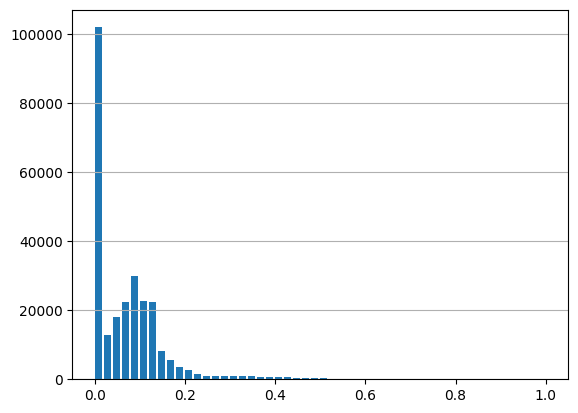

In [13]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50, width = 0.015555)
plt.grid(axis = 'y')

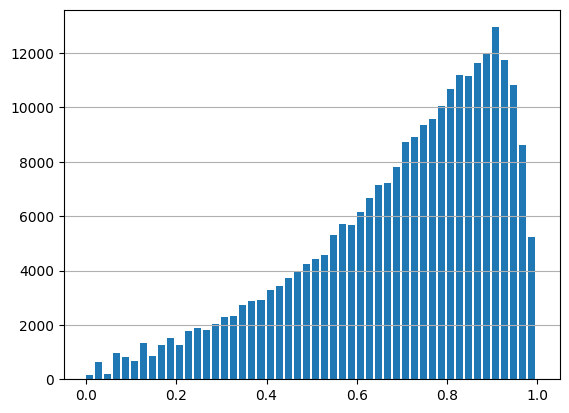

In [14]:
plt.hist(loan_data_defaults['CCF'], bins = 50, width = 0.015555)
plt.grid(axis = 'y')

In [15]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
loan_data_defaults['recovery_rate_0_1'].head(10)

5040     0
25963    0
41393    0
55148    0
58105    0
60604    0
62536    0
64081    0
67928    0
68761    0
Name: recovery_rate_0_1, dtype: int64

Since there isn't any Python libraries that provide a built-in stable Beta regression model, the LGD model is estimated using the combination of logistic regression model and linear regression model.
* **Stage (1)** the logistic regression model is used to estimate whether the recovery rate, **recovery_rate**, is 0;
* **Stage (2)** the linear regression model is used to estimate the recovery rate if the recovery rate is larger than 0.

## LGD Modeling Stage 1 - Logistic Regression

### Split the Data

Split the dataframe into 80% training data and 20% testing data and set **random_state** to 20.

In [16]:
from sklearn.model_selection import train_test_split

seed_id = 20

In [17]:
lgd_inputs_stage1_train, lgd_inputs_stage1_test, lgd_targets_stage1_train, lgd_targets_stage1_test = train_test_split(loan_data_defaults.drop(['recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = seed_id)

Observe the training inputs and targets dataframe.

In [18]:
lgd_inputs_stage1_train.shape

(209932, 279)

In [19]:
lgd_targets_stage1_train.shape

(209932,)

Observe the testing inputs and targets dataframe.

In [20]:
lgd_inputs_stage1_test.shape

(52484, 279)

In [21]:
lgd_targets_stage1_test.shape

(52484,)

### Prepare the Inputs Data

In [22]:
selected_explanatory_variables = [
    # grade
    'grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    # home_ownership
    'home_ownership:MORTGAGE',
    'home_ownership:NONE',
    'home_ownership:OTHER',
    'home_ownership:OWN',
    'home_ownership:RENT',
    # verification_status
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    # purpose
    'purpose:car',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:educational',
    'purpose:home_improvement',
    'purpose:house',
    'purpose:major_purchase',
    'purpose:medical',
    'purpose:moving',
    'purpose:other',
    'purpose:renewable_energy',
    'purpose:small_business',
    'purpose:vacation',
    'purpose:wedding',
    # initial_list_status
    'initial_list_status:f',
    'initial_list_status:w',
    # term_int
    'term_int',
    # emp_length_int
    'emp_length_int',
    # mths_since_issue_d
    'mths_since_issue_d',
    # mths_since_earliest_cr_line
    'mths_since_earliest_cr_line',
    # funded_amnt
    'funded_amnt',
    # int_rate
    'int_rate',
    # installment
    'installment',
    # annual_inc
    'annual_inc',
    # dti
    'dti',
    # delinq_2yrs
    'delinq_2yrs',
    # inq_last_6mths
    'inq_last_6mths',
    # mths_since_last_delinq
    'mths_since_last_delinq',
    # mths_since_last_record
    'mths_since_last_record',
    # open_acc
    'open_acc',
    # pub_rec
    'pub_rec',
    # total_acc
    'total_acc',
    # acc_now_delinq
    'acc_now_delinq',
    # total_rev_hi_lim
    'total_rev_hi_lim']

In [23]:
reference_category = [
    'grade:G',
    'home_ownership:RENT',
    'verification_status:Verified',
    'purpose:credit_card',
    'initial_list_status:f']

In [24]:
pd.options.display.max_rows = None
lgd_inputs_stage1_train = lgd_inputs_stage1_train.loc[: , selected_explanatory_variables]
lgd_inputs_stage1_train = lgd_inputs_stage1_train.drop(reference_category, axis = 1)
lgd_inputs_stage1_train.head(10)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
720439,False,False,False,False,False,True,False,False,False,True,...,39.18,0.0,1.0,45.0,0.0,10.0,0.0,18.0,0.0,55700.0
2070989,False,False,False,True,False,False,False,False,False,False,...,13.94,0.0,0.0,0.0,100.0,6.0,1.0,9.0,0.0,12500.0
633898,False,False,False,False,True,False,False,False,False,False,...,21.38,0.0,1.0,0.0,0.0,17.0,0.0,42.0,0.0,4600.0
1175862,False,False,False,False,False,True,True,False,False,False,...,14.58,0.0,2.0,76.0,0.0,14.0,0.0,24.0,0.0,28500.0
506328,False,False,False,True,False,False,True,False,False,False,...,11.26,2.0,0.0,8.0,0.0,11.0,0.0,39.0,0.0,115400.0
828778,False,False,False,False,True,False,True,False,False,False,...,17.16,6.0,4.0,12.0,0.0,11.0,0.0,35.0,0.0,10500.0
814213,False,False,True,False,False,False,False,False,False,False,...,12.02,0.0,2.0,0.0,0.0,11.0,0.0,16.0,0.0,8000.0
1286490,False,False,False,True,False,False,False,False,False,False,...,8.79,2.0,2.0,3.0,0.0,21.0,0.0,39.0,0.0,47100.0
1785928,False,False,True,False,False,False,False,False,False,False,...,28.23,1.0,0.0,21.0,0.0,9.0,0.0,19.0,0.0,18100.0
1760703,False,True,False,False,False,False,False,False,False,False,...,10.38,0.0,1.0,0.0,0.0,15.0,0.0,26.0,0.0,48000.0


Check the number of columns/features in the dataframe, **lgd_inputs_stage1_train**

In [25]:
print('Number of features expected: {}'.format(len(selected_explanatory_variables) - len(reference_category)))
print('Number of features in dataframe: {}'.format(lgd_inputs_stage1_train.shape[1]))

Number of features expected: 44
Number of features in dataframe: 44


### Estimate the LGD Model: Stage 1

Import Scikit-Learn libraries

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import scipy.stats as stat

Retrieve the implemented class **LogisticRegression_p_values** from Section 1 - Preparation.

In [27]:
class LogisticRegression_p_values:
    def __init__(self, *args, **kwargs):
        self.model = LogisticRegression(*args, **kwargs)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_

        # calculate p_values for each coefficient
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom, (X.shape[1], 1)).T
        F_ij = np.dot((X / denom).T, X)
        F_ij_float64 = F_ij.astype(np.float64)
        Cramer_Rao = np.linalg.inv(F_ij_float64)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.p_values = np.append(np.nan, np.round(p_values, 3))

In [28]:
logistic_reg_lgd_stage1_model = LogisticRegression_p_values()
logistic_reg_lgd_stage1_model.fit(lgd_inputs_stage1_train, lgd_targets_stage1_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
feature_name = lgd_inputs_stage1_train.columns.values
summary_table1 = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table1['Coefficients'] = np.transpose(logistic_reg_lgd_stage1_model.coef_)
summary_table1.index = summary_table1.index + 1
summary_table1.loc[0] = ['Intercept', logistic_reg_lgd_stage1_model.intercept_[0]]
summary_table1 = summary_table1.sort_index()
summary_table1['p_values'] = logistic_reg_lgd_stage1_model.p_values
summary_table1['p > 0.05'] = np.where((summary_table1['p_values'] > 0.05), "*", "")

In [30]:
pd.options.display.max_rows = None
summary_table1

,Feature name,Coefficients,p_values,p > 0.05
0,Intercept,3.409342e-06,NaN,
1,grade:A,-1.068817e-04,0.998,*
2,grade:B,-5.865434e-05,0.998,*
3,grade:C,5.105346e-05,0.999,*
4,grade:D,2.809458e-05,0.999,*
5,grade:E,4.172548e-05,0.999,*
6,grade:F,3.436718e-05,0.999,*
7,home_ownership:MORTGAGE,5.738750e-05,0.996,*
8,home_ownership:NONE,1.729919e-07,1.000,*
9,home_ownership:OTHER,6.697545e-07,1.000,*


### Test the LGD Model **logistic_reg_lgd_stage1_model** on Testing Data

In [31]:
lgd_inputs_stage1_test = lgd_inputs_stage1_test.loc[: , selected_explanatory_variables]
lgd_inputs_stage1_test = lgd_inputs_stage1_test.drop(reference_category, axis = 1)
lgd_inputs_stage1_test.head(10)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
1066604,False,False,False,True,False,False,False,False,False,False,...,15.13,1.0,0.0,1.0,0.0,12.0,0.0,33.0,1.0,10000.0
1317927,False,False,True,False,False,False,True,False,False,False,...,11.25,0.0,1.0,0.0,0.0,5.0,0.0,14.0,0.0,14400.0
1268166,False,False,False,False,True,False,False,False,False,False,...,25.68,0.0,0.0,25.0,0.0,16.0,0.0,38.0,0.0,6600.0
1060513,False,False,False,False,True,False,True,False,False,False,...,26.85,0.0,0.0,0.0,51.0,13.0,2.0,19.0,0.0,24800.0
1520826,False,False,True,False,False,False,False,False,False,False,...,18.34,0.0,0.0,0.0,0.0,7.0,0.0,26.0,0.0,21100.0
1285134,False,False,False,False,True,False,False,False,False,False,...,33.19,0.0,0.0,0.0,0.0,6.0,0.0,24.0,0.0,17000.0
937405,False,False,False,False,False,True,False,False,False,False,...,0.67,0.0,3.0,0.0,0.0,3.0,0.0,4.0,0.0,3400.0
1780979,False,False,False,False,False,True,False,False,False,False,...,26.47,0.0,1.0,0.0,0.0,13.0,0.0,15.0,0.0,30400.0
1120537,False,False,False,True,False,False,True,False,False,False,...,8.48,1.0,1.0,17.0,0.0,8.0,0.0,27.0,0.0,54000.0
580713,False,False,True,False,False,False,False,False,False,False,...,32.38,0.0,0.0,0.0,0.0,4.0,0.0,11.0,0.0,9000.0


In [32]:
print('Number of features expected: {}'.format(len(selected_explanatory_variables) - len(reference_category)))
print('Number of features in dataframe: {}'.format(lgd_inputs_stage1_test.shape[1]))

Number of features expected: 44
Number of features in dataframe: 44


In [33]:
y_hat_test_lgd_stage1 = logistic_reg_lgd_stage1_model.model.predict(lgd_inputs_stage1_test)
y_hat_test_prob_lgd_stage1 = logistic_reg_lgd_stage1_model.model.predict_proba(lgd_inputs_stage1_test)

Keep the estimated probabilities of recovery rates that larger than 0.

In [34]:
y_hat_test_prob_lgd_stage1 = y_hat_test_prob_lgd_stage1[ : ][ : , 1]

In [35]:
lgd_targets_stage1_test_temp = lgd_targets_stage1_test.copy()
lgd_targets_stage1_test_temp.reset_index(drop = True, inplace = True)
df_actual_predicted_prob = pd.concat([lgd_targets_stage1_test_temp, pd.DataFrame(y_hat_test_lgd_stage1), pd.DataFrame(y_hat_test_prob_lgd_stage1)], axis = 1)
df_actual_predicted_prob.columns = ['lgd_targets_stage1_test', 'y_hat_test', 'y_hat_test_prob']
df_actual_predicted_prob.index = lgd_targets_stage1_test.index
df_actual_predicted_prob.head(10)

,lgd_targets_stage1_test,y_hat_test,y_hat_test_prob
1066604,1,1,0.722336
1317927,1,1,0.781697
1268166,1,1,0.768018
1060513,0,1,0.632439
1520826,0,0,0.477293
1285134,0,1,0.731374
937405,0,1,0.752233
1780979,1,1,0.892137
1120537,1,1,0.744359
580713,1,1,0.569939


### Model Accuracy Estimation

Plot the Confusion Matrix when the threshold is set to 0.5 (y_hat_test_prob > 0.5).

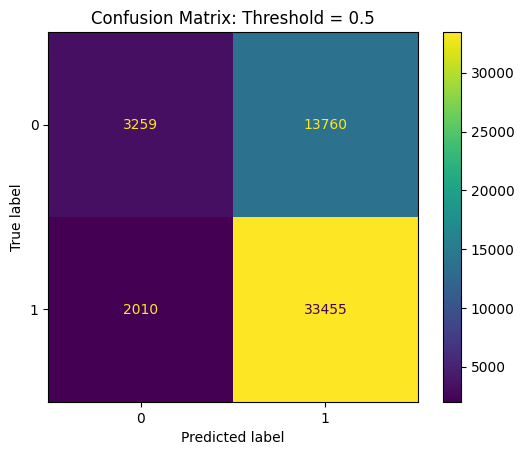

In [36]:
cm = confusion_matrix(lgd_targets_stage1_test, y_hat_test_lgd_stage1, labels = logistic_reg_lgd_stage1_model.model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logistic_reg_lgd_stage1_model.model.classes_)
disp.plot()
plt.title('Confusion Matrix: Threshold = 0.5')
plt.show()

Accuracy and Area Under the Curve (AUC)

In [37]:
false_positive_rate, true_positive_rate, threshold = roc_curve(df_actual_predicted_prob['lgd_targets_stage1_test'], df_actual_predicted_prob['y_hat_test_prob'])

Text(0.5, 1.0, 'ROC Curve')

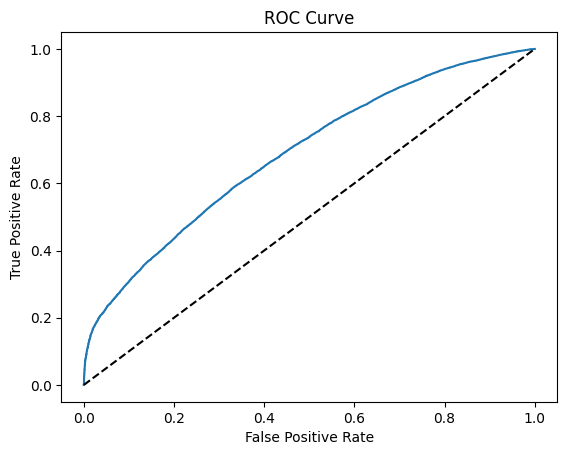

In [38]:
plt.plot(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, false_positive_rate, linestyle = '--', color = 'k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [39]:
Area_Under_ROC = roc_auc_score(df_actual_predicted_prob['lgd_targets_stage1_test'], df_actual_predicted_prob['y_hat_test_prob'])
print(Area_Under_ROC)

0.6878038723806477


Based on the metric, the model is fair and has just enough predictive power.

## LGD Modeling Stage 2 - Linear Regression

### Data Preparation for LGD Modeling Stage 2

Prepare the training and testing dataset with 80/20 proportion.

In [40]:
lgd_stage2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1].copy()
lgd_inputs_stage2_train, lgd_inputs_stage2_test, lgd_targets_stage2_train, lgd_targets_stage2_test = train_test_split(lgd_stage2_data.drop(['recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage2_data['recovery_rate'], test_size = 0.2, random_state = seed_id)

Import Scikit-Learn libraries

In [41]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score

Calculate the p-value of each model coefficient since the calculation is not included in original LinearRegression function from Scikit-Learn library.

In [42]:
class LinearRegression_p_values:
    def __init__(self):
        self.model = linear_model.LinearRegression(fit_intercept = True, copy_X = True, n_jobs = 1)
    
    def fit(self, X, y, n_jobs = 1):
        self.model.fit(X, y, n_jobs)
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_

        # calculate p_values for each coefficient
        sse = np.sum((self.model.predict(X) - y) ** 2, axis = 0) / float(X.shape[0] - X.shape[1])
        Xt_dot_X = np.dot(X.T, X)
        Xt_dot_X_float64 = Xt_dot_X.astype(np.float64)
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(Xt_dot_X_float64)))])
        self.t = self.coef_ / se
        p_values = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        self.p_values = np.append(np.nan, np.round(p_values, 3))

In [43]:
lgd_inputs_stage2_train = lgd_inputs_stage2_train.loc[: , selected_explanatory_variables]
lgd_inputs_stage2_train = lgd_inputs_stage2_train.drop(reference_category, axis = 1)
lgd_inputs_stage2_train.head(10)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
1319257,False,False,True,False,False,False,False,False,False,False,...,23.88,0.0,0.0,0.0,0.0,10.0,0.0,13.0,0.0,19200.0
1475775,False,False,False,False,True,False,False,False,False,False,...,23.80,0.0,3.0,0.0,82.0,25.0,1.0,52.0,0.0,39700.0
955967,False,False,True,False,False,False,False,False,False,False,...,11.20,0.0,1.0,0.0,35.0,11.0,1.0,47.0,0.0,19600.0
1695678,False,True,False,False,False,False,False,False,False,True,...,16.28,3.0,0.0,19.0,0.0,11.0,0.0,20.0,0.0,47400.0
756106,False,False,False,True,False,False,True,False,False,False,...,30.30,1.0,0.0,19.0,39.0,13.0,1.0,20.0,0.0,17700.0
590237,False,False,False,False,True,False,False,False,False,True,...,16.05,0.0,2.0,0.0,0.0,6.0,0.0,11.0,0.0,7700.0
1620642,False,True,False,False,False,False,True,False,False,False,...,17.21,0.0,3.0,73.0,0.0,19.0,0.0,24.0,0.0,57800.0
2119977,False,False,False,True,False,False,False,False,False,False,...,16.81,0.0,2.0,0.0,0.0,12.0,0.0,53.0,0.0,25000.0
1280916,False,False,False,False,True,False,True,False,False,False,...,21.29,1.0,0.0,4.0,0.0,10.0,0.0,36.0,0.0,12200.0
1996254,False,False,True,False,False,False,False,False,False,False,...,9.79,2.0,1.0,9.0,0.0,12.0,0.0,28.0,0.0,14100.0


Check the processed the data against the expected one.

In [44]:
print('Number of features expected: {}'.format(len(selected_explanatory_variables) - len(reference_category)))
print('Number of features in dataframe: {}'.format(lgd_inputs_stage2_train.shape[1]))

Number of features expected: 44
Number of features in dataframe: 44


### Estimate the LGD Model: Stage 2

In [45]:
linear_reg_lgd_stage2_model = LinearRegression_p_values()
linear_reg_lgd_stage2_model.fit(lgd_inputs_stage2_train, lgd_targets_stage2_train)

In [46]:
feature_name = lgd_inputs_stage2_train.columns.values
summary_table2 = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table2['Coefficients'] = np.transpose(linear_reg_lgd_stage2_model.coef_)
summary_table2.index = summary_table2.index + 1
summary_table2.loc[0] = ['Intercept', linear_reg_lgd_stage2_model.intercept_]
summary_table2 = summary_table2.sort_index()
summary_table2['p_values'] = linear_reg_lgd_stage2_model.p_values
summary_table2['p > 0.05'] = np.where((summary_table2['p_values'] > 0.05), "*", "")
summary_table2

,Feature name,Coefficients,p_values,p > 0.05
0,Intercept,1.374851e-01,NaN,
1,grade:A,-3.219985e-02,0.000,
2,grade:B,-3.396355e-02,0.000,
3,grade:C,-2.843210e-02,0.000,
4,grade:D,-1.954267e-02,0.000,
5,grade:E,-1.214398e-02,0.000,
6,grade:F,-4.702745e-03,0.013,
7,home_ownership:MORTGAGE,4.017204e-03,0.000,
8,home_ownership:NONE,2.794834e-01,0.000,
9,home_ownership:OTHER,4.235523e-02,0.017,


### Model Validation: Stage 2

Prepare the input data for testing

In [47]:
lgd_inputs_stage2_test = lgd_inputs_stage2_test.loc[: , selected_explanatory_variables]
lgd_inputs_stage2_test = lgd_inputs_stage2_test.drop(reference_category, axis = 1)
lgd_inputs_stage2_test.head(10)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
1775160,False,False,False,False,False,False,True,False,False,False,...,20.26,1.0,1.0,12.0,0.0,7.0,0.0,24.0,0.0,3600.0
1059507,False,True,False,False,False,False,False,False,False,False,...,31.04,0.0,0.0,0.0,67.0,14.0,1.0,46.0,0.0,24200.0
1306369,False,False,True,False,False,False,False,False,False,False,...,36.62,2.0,2.0,7.0,0.0,21.0,0.0,51.0,0.0,21700.0
1995415,False,False,False,False,False,True,False,False,False,False,...,30.26,1.0,2.0,20.0,0.0,6.0,0.0,19.0,0.0,4100.0
1970274,False,False,False,False,True,False,True,False,False,False,...,27.44,0.0,0.0,0.0,0.0,9.0,0.0,26.0,0.0,25400.0
1121709,False,False,True,False,False,False,True,False,False,False,...,16.03,4.0,3.0,6.0,0.0,10.0,0.0,18.0,0.0,26900.0
1655374,False,False,False,False,True,False,True,False,False,False,...,9.75,0.0,1.0,33.0,0.0,5.0,0.0,9.0,0.0,3100.0
1111041,False,False,False,False,True,False,False,False,False,False,...,28.06,0.0,2.0,0.0,118.0,9.0,1.0,40.0,0.0,5000.0
1567401,False,True,False,False,False,False,False,False,False,False,...,21.85,0.0,1.0,0.0,0.0,8.0,0.0,23.0,0.0,28900.0
1125705,False,False,False,False,False,True,True,False,False,False,...,33.90,0.0,0.0,0.0,0.0,14.0,0.0,23.0,0.0,24100.0


Check the number of features in the dataframe **lgd_inputs_stage2_test** against the expected value.

In [48]:
print('Number of features expected: {}'.format(len(selected_explanatory_variables) - len(reference_category)))
print('Number of features in dataframe: {}'.format(lgd_inputs_stage2_test.shape[1]))

Number of features expected: 44
Number of features in dataframe: 44


Estimate the recovery rate using the trained linear regression model **linear_reg_lgd_stage2_model**.

In [49]:
y_hat_test_lgd_stage2 = linear_reg_lgd_stage2_model.model.predict(lgd_inputs_stage2_test)

In [50]:
lgd_targets_stage2_test_temp = lgd_targets_stage2_test.copy()
lgd_targets_stage2_test_temp = lgd_targets_stage2_test_temp.reset_index(drop = True)
pd.concat([lgd_targets_stage2_test_temp, pd.DataFrame(y_hat_test_lgd_stage2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.209535
0,0.209535,1.000000


Based on the correlation, there's a weak-moderate positive correlation, and the value is satisfactory for a LGD model.

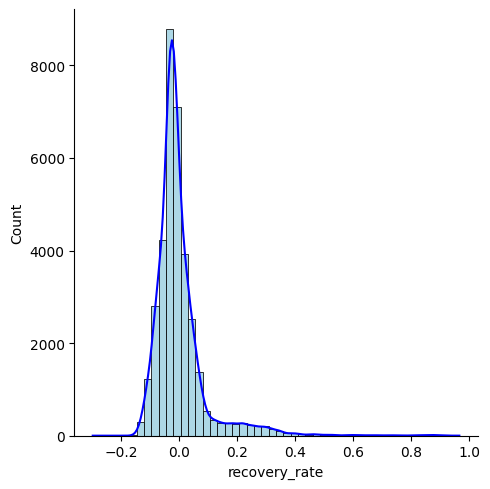

In [51]:
import seaborn as sns

ax = sns.displot(lgd_targets_stage2_test - y_hat_test_lgd_stage2, kde = True, color = 'blue', bins = 50, facecolor = 'lightblue', edgecolor = 'black')

The graph shows that the distribution resembles a Normal distribution, and most residuals are symmetrically distributed around 0, indicating that this is a good methodology.

## LGD Modeling: Combine Stage 1 and 2

### Estimate All Testing Data using the Second Model **linear_reg_lgd_stage2_model**

Since the recovery rate predicted by the model at stage 1 **logistic_reg_lgd_stage1_model** is 0 for rate that is 0 and 1 for rate that is larger than 0, all values predicted by the model at stage 2 **linear_reg_lgd_stage2_model** are multiplied by 0 will remain 0; similarly, values from model at stage 2 are multiplied by 1 will remain the same.

In [52]:
y_hat_test_lgd_stage2_all = linear_reg_lgd_stage2_model.model.predict(lgd_inputs_stage1_test)
y_hat_test_lgd = y_hat_test_lgd_stage1 * y_hat_test_lgd_stage2_all
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,52484.000000
mean,0.097884
std,0.037399
min,-0.078048
25%,0.092047
50%,0.107853
75%,0.120178
max,0.367317


In [53]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,52484.000000
mean,0.097886
std,0.037393
min,0.000000
25%,0.092047
50%,0.107853
75%,0.120178
max,0.367317


## Exposure at Default Modeling

### Split and Observe the Data **loan_data_defaults**

Split the default loan data into training and testing set (80/20).

In [55]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = seed_id)

Check if the number of features is expected in the targets and testing dataset.

In [56]:
ead_inputs_train.shape

(262396, 279)

In [57]:
ead_targets_train.shape

(262396,)

In [58]:
ead_inputs_test.shape

(20, 279)

In [59]:
ead_targets_test.shape

(20,)

### Data Preparation for EAD Model Input